Гафни Даниил, 306 группа, физический факультет МГУ

### Импортируем необходимые библиотеки

In [1]:
import numpy as np

import plotly
import plotly.graph_objs as go

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

import warnings

from IPython.display import clear_output, HTML, display, Image

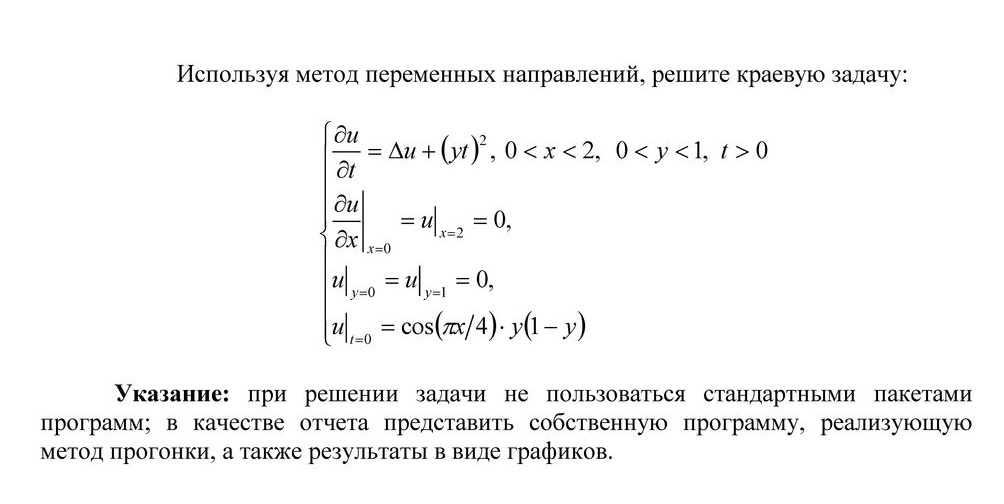

In [2]:
Image("task.jpg")

### Проведем необходимые настройки

In [3]:
plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
class HeatEquationSolver_1:
    '''
    Класс для численного решения одномерного уравнения теплопроводности.
    '''
    
    def __init__(self,
                 X_START=0, X_END=2,
                 T_START=0, T_END=10,
                N=5, M=5):
        
        # Задание параметров сетки
        self.X_START = X_START
        self.X_END = X_END
        self.T_START = T_START
        self.T_END = T_END
        self.N = N
        self.M = M
        
        self.x = np.linspace(X_START, X_END, N)
        self.t = np.linspace(T_START, T_END, M)
        
        self.dx = self.x[1] - self.x[0]
        self.dt = self.t[1] - self.t[0]
    
    def initialize(self, a, f, fi, gamma1, gamma2, delta2, delta1, mu1, mu2):
        
        self.a = a
        self.f = f
        self.fi = fi
        self.gamma1 = gamma1
        self.gamma2 = gamma2
        self.delta1 = delta1
        self.delta2 = delta2
        self.mu1 = mu1
        self.mu2 = mu2
        
        self.u = np.zeros((self.N, self.M))
        
        self.u[0] = self.fi(self.x)
        self.u.T[0] = self.mu1(self.t)
        self.u.T[-1] = self.mu2(self.t)
        
    def calculate_layer(self, m, step_x, step_t):
        '''
        Метод, вычисляющий следующий слой. 
        
        Параметры:
            m (int): номер слоя для вычисления
            step_x (float): шаг по x
            step_t (float): шаг по t
        '''
        
        m = m-1
        coeffs = np.zeros((self.N, self.N))
        coeffs[0][0] = self.gamma1/(step_x*self.delta1 + self.gamma1)
        coeffs[0][1] = step_x*self.mu1(self.t[m+1])/(step_x*self.delta1 + self.gamma1)
        coeffs[-1][-1] = self.gamma1/(step_x*self.delta1 + self.gamma1)
        coeffs[-1][-2] = step_x*self.mu1(self.t[m+1])/(step_x*self.delta1 + self.gamma1)
        
        for i in range(1, coeffs.shape[0]-1):
            coeffs[i][i-1] = self.a**2*step_t/step_x
            coeffs[i][i] = -2*self.a**2*step_t*(step_x**2 + 1)
            coeffs[i][i+1] = coeffs[i][i]
        
        F = np.array([-step_x/self.mu1(self.u[0][m+1]/(step_x*self.delta1+self.gamma1))] + 
                     [(f(self.x[i], self.t[m]))*step_t-self.u[i][m] for i in range(1, self.N-2)] +
                     [-step_x/self.mu2(self.u[-1][m+1]/(step_x*self.delta2+self.gamma2))])
        
        new_layer = self.TDMA(coeffs, F)
        
        #self.u[m+1] = np.array([self.u[m+1][0]] + list(new_layer))
        self.u[m+1] = new_layer
        
    def calculate_u(self):
        for i in range(1, self.M):
            self.calculate_layer(i, step_x = self.dx, step_t = self.dt)
        
    def TDMA(self, coeffs, F):
        '''
        Метод прогонки.
        
        Параметры: 
            data (numpy.array): Трехдианональная матрица коэффициентов уравнений.
            F (numpy.array): Массив правых частей уравнений.
        '''
        
        kappa1, nu1 = -data[0][1]/data[0][0], F[0]/data[0][0]
        kappa2, nu2 = -data[-1][-2]/data[-1][-1], F[-1]/data[-1][-1]
        coeffs = data[1:-1]
        alphas = [kappa1]
        betas = [nu1]
        N = data.shape[0]
        Y = [0]*N
    
        for i in range(N-2):
            alphas.append(-coeffs[i][i+2] / (coeffs[i][i+1] + alphas[i]*coeffs[i][i]))
            betas.append((F[i+1] - betas[i]*coeffs[i][i]) / (coeffs[i][i+1] + alphas[i]*coeffs[i][i]))
    
        Y[-1] = (nu2 + kappa2*betas[-1]) / (1 - alphas[-1]*kappa2)
        for i in reversed(range(N-1)):
            Y[i] = alphas[i]*Y[i+1] + betas[i]
    
        return(Y)
    
    def plot_u(self, filename='OMM_Task_2', online=True):
        '''
        Метод, который строит 3D график численного решения.
        '''
        
        x_, t_, u_ = self.x, self.t, self.u
        data = [go.Surface(x = x_, y = t_, z = u_.T, colorscale = 'YlGnBu')]
        # Наведем красоту
        layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='x',
                        gridcolor="rgb(255, 255, 255)",
                        zerolinecolor="rgb(255, 255, 255)",
                        showbackground=True,
                        backgroundcolor="rgb(200, 200, 230)"),
                        
                    yaxis = dict(
                        title='t',
                        gridcolor="rgb(255, 255, 255)",
                        zerolinecolor="rgb(255, 255, 255)",
                        showbackground=True,
                        backgroundcolor="rgb(230, 200,230)"),
                        
                    zaxis = dict(
                        title='u(x, t)',
                        gridcolor="rgb(255, 255, 255)",
                        zerolinecolor="rgb(255, 255, 255)",
                        showbackground=True,
                        backgroundcolor="rgb(230, 230,200)",),),
                    width=800, height=600, 
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10)
                  )

        fig = go.Figure(data = data, layout = layout)
        if not online:
            return plotly.offline.iplot(fig, filename = filename)  # построение графика оффлайн влечет за собой
                                        # большой вес ноутбука, но построение почти мгновенное
        if online:
            return py.iplot(fig, filename = filename)  # Построение графика онлайн - маленький вес ноутбука, 
                                        # сравнительно долгое построение

In [15]:
a = 1
def f(x, t):
    return np.cos(np.pi*x/4)
def fi(x):
    return np.sin(x)+1
gamma1 = 1
gamma2 = 1
delta1 = 1
delta2 = 1
def mu1(t):
    return 1
def mu2(t):
    return 1

In [16]:
solver = HeatEquationSolver_1(N = 100, M = 100)
solver.initialize(a, f, fi, gamma1, gamma2, delta2, delta1, mu1, mu2)

In [17]:
solver.calculate_u()
solver.plot_u()

ValueError: cannot copy sequence with size 4 to array axis with dimension 100

In [18]:
data = np.array(
    [
    [1, 2, 0, 0],
    [2, 3, 4, 0],
    [0, 5, 3, 2],
    [0, 0, 7, 6]
    ]
)
F = np.array([1, 2, 3, 5])
#2, 1, 1
solver.TDMA(data, F)

[0.4838709677419355,
 0.25806451612903225,
 0.06451612903225806,
 0.7580645161290323]

In [ ]:
tdma(data, F)